In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.io.wavfile
import scipy.signal
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter, sosfilt, sosfreqz, filtfilt, sosfiltfilt
from scipy.fft import fft, fftfreq

In [2]:
plt.rcParams["figure.figsize"] = (20,10)

In [3]:
df = pd.read_csv("ECG_Rhythm_Lead_I.csv")
df.shape

(21837, 1007)

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y

In [5]:
def plot_signals(data, filtered_data):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.set_title('Raw ECG')
    ax1.plot(data, color='r');
    ax1.grid(True)
    ax2.set_title('Filtered ECG ['+str(lowcut)+'Hz - '+str(highcut)+'Hz]')
    ax2.plot(filtered_data, color='r');
    ax2.set_xlabel('Time [100 miliseconds]');
    plt.tight_layout()
    ax2.grid(True)
    plt.show();

In [6]:
del df["Unnamed: 0"]

In [7]:
df = df.loc[df.rhythm_diag != 'OTHER']
df.shape

(18296, 1006)

In [8]:
df.rhythm_diag.value_counts()

SR      16782
AFIB     1514
Name: rhythm_diag, dtype: int64

In [9]:
df

,ecg_id,age,sex,height,weight,rhythm_diag,0,1,2,3,...,990,991,992,993,994,995,996,997,998,999
0,1,56.0,1,NaN,63.0,SR,-0.119,-0.116,-0.120,-0.117,...,0.198,0.194,0.115,0.107,0.107,0.106,0.090,0.069,0.086,0.022
2,3,37.0,1,NaN,69.0,SR,-0.029,-0.035,-0.054,-0.078,...,-0.040,-0.051,-0.026,-0.032,-0.052,-0.039,-0.034,-0.029,-0.048,-0.049
3,4,24.0,0,NaN,82.0,SR,-0.054,-0.053,-0.063,-0.060,...,-0.312,-0.511,-0.280,-0.076,-0.012,0.001,-0.003,0.026,0.026,0.028
4,5,19.0,1,NaN,70.0,SR,-0.034,-0.038,-0.057,-0.066,...,0.005,0.001,0.003,0.013,0.018,-0.001,0.007,0.000,-0.003,-0.012
5,6,18.0,1,NaN,58.0,SR,-0.032,-0.018,0.020,0.021,...,-0.126,-0.108,-0.069,-0.028,-0.105,-0.080,-0.213,-0.159,-0.206,-0.419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21831,21832,63.0,0,NaN,NaN,SR,-0.076,-0.066,-0.049,-0.041,...,-0.002,-0.026,-0.014,-0.008,-0.033,-0.072,-0.124,-0.132,-0.081,-0.047
21833,21834,93.0,0,NaN,NaN,SR,-0.050,-0.032,0.008,0.014,...,-0.023,-0.052,-0.062,-0.059,-0.074,-0.069,-0.107,0.058,0.501,0.584
21834,21835,59.0,1,NaN,NaN,SR,0.038,0.078,-0.014,0.072,...,-0.081,0.012,0.504,0.613,0.328,0.061,0.037,-0.106,-0.045,0.463
21835,21836,64.0,1,NaN,NaN,SR,-0.057,-0.041,0.003,0.000,...,0.074,0.112,0.116,0.115,0.112,0.096,0.051,0.033,0.027,-0.006


In [10]:
df.replace({'rhythm_diag': {'SR': 0, 'AFIB': 1}}, inplace=True)
df.rhythm_diag.value_counts()

0    16782
1     1514
Name: rhythm_diag, dtype: int64

In [11]:
from sklearn.utils import resample

In [12]:
df_minority = df[df['rhythm_diag']==1]
df_majority = df[df['rhythm_diag']==0]

In [13]:
maj_class = resample(df_majority,
                     replace=True,
                     n_samples=1514,
                     random_state=123)

In [14]:
maj_class.shape

(1514, 1006)

In [15]:
df=pd.concat([df_minority,maj_class])
df.shape

(3028, 1006)

In [16]:
df.rhythm_diag.value_counts()

0    1514
1    1514
Name: rhythm_diag, dtype: int64

In [17]:
df[df.rhythm_diag == 0]['age'].mean()

57.76275679257787

In [18]:
df[df.rhythm_diag == 1]['age'].mean()

70.79839249832551

In [19]:
X = df.drop(['ecg_id', 'age', 'sex', 'height', 'weight', 'rhythm_diag'], axis=1).values
y = df.rhythm_diag.values
X.shape, y.shape

((3028, 1000), (3028,))

In [19]:
df[df.rhythm_diag == 0]['sex'].mean()

0.4960369881109643

In [20]:
df[df.rhythm_diag == 1]['sex'].mean()

0.4425363276089828

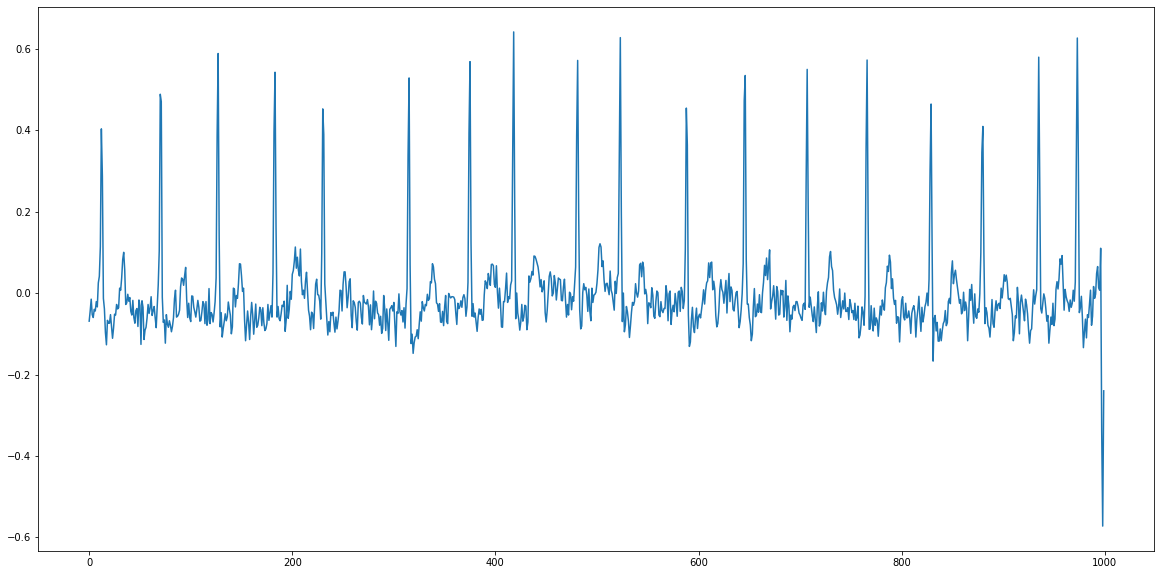

In [20]:
plt.plot(X[51]);

In [86]:
y[2000:2030]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [21]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter

In [113]:
windowSize = 7
window = np.hanning(windowSize)
window = window / window.sum()

# filter the data using convolution
m_a_filtered = np.convolve(window,X[51], mode='valid')

Text(0.5, 1.0, 'Filtered')

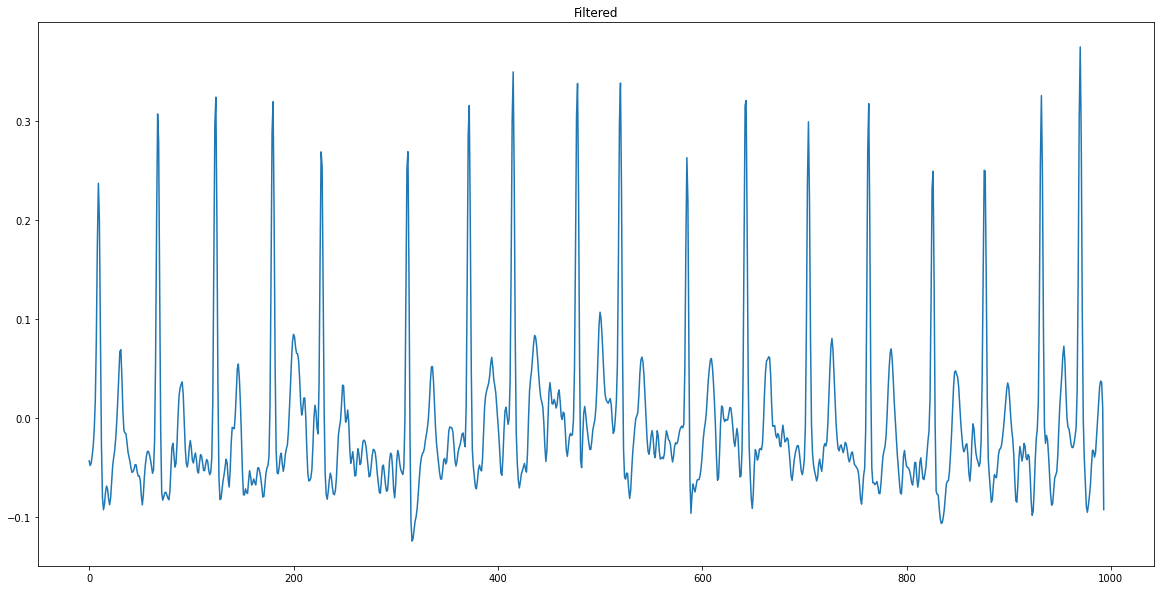

In [114]:
plt.plot(m_a_filtered)
plt.title("Filtered")

In [21]:
fs = 100.0
lowcut = 0.67
highcut = 49

In [22]:
from scipy.signal import butter, sosfilt, sosfreqz, filtfilt

In [23]:
def butter_highpass(cutoff, sample_rate, order=2):
    '''standard highpass filter.

    Function that defines standard Butterworth highpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies below cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default : 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    we can specify the cutoff and sample_rate as ints or floats.

    >>> b, a = butter_highpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_highpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [24]:
def butter_lowpass(cutoff, sample_rate, order):
    '''standard lowpass filter.

    Function that defines standard Butterworth lowpass filter

    Parameters
    ----------
    cutoff : int or float
        frequency in Hz that acts as cutoff for filter.
        All frequencies above cutoff are filtered out.

    sample_rate : int or float
        sample rate of the supplied signal

    order : int
        filter order, defines the strength of the roll-off
        around the cutoff frequency. Typically orders above 6
        are not used frequently.
        default: 2
    
    Returns
    -------
    out : tuple
        numerator and denominator (b, a) polynomials
        of the defined Butterworth IIR filter.

    Examples
    --------
    >>> b, a = butter_lowpass(cutoff = 2, sample_rate = 100, order = 2)
    >>> b, a = butter_lowpass(cutoff = 4.5, sample_rate = 12.5, order = 5)
    '''
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [25]:
def lowpass(data, fs, cutoff_low, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

In [26]:
def highpass(data, fs,cutoff_high, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

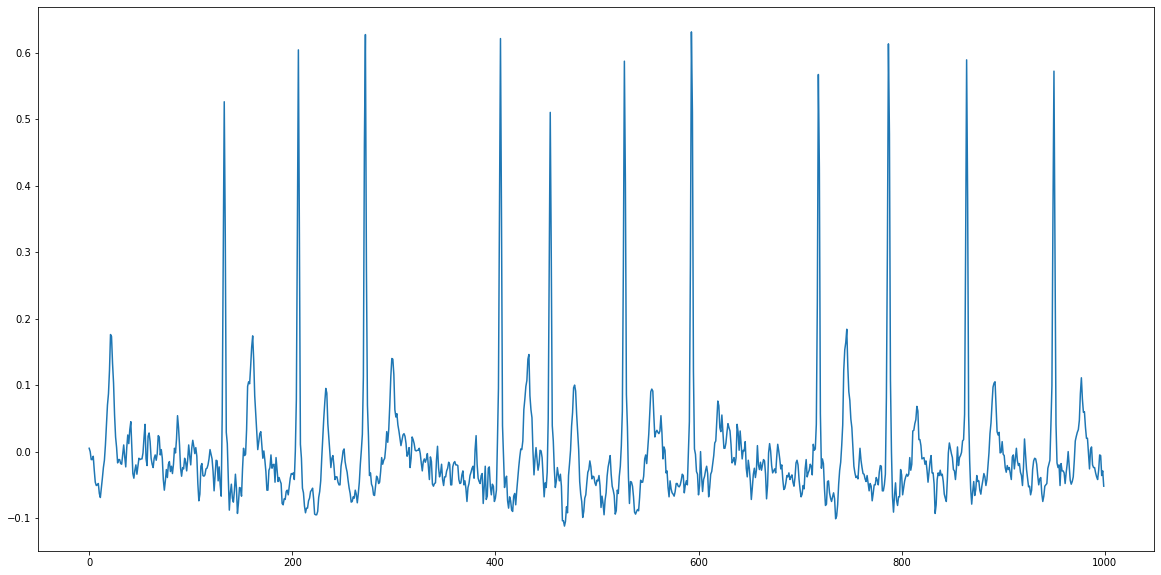

In [27]:
plt.plot(X[294])

In [39]:
b, a = butter_highpass(0.67, 100, 2)
#filtered_data = filtfilt(b, a, m_a_filtered)
filtered_data = filtfilt(b, a, X[294])

In [40]:
final_filtered_data = lowpass(filtered_data, 100, 49, 5)
#c, d = butter_lowpass(49, 100, 2)
#final_filtered_data = filtfilt(c, d, filtered_data)

<Figure size 1440x720 with 0 Axes>

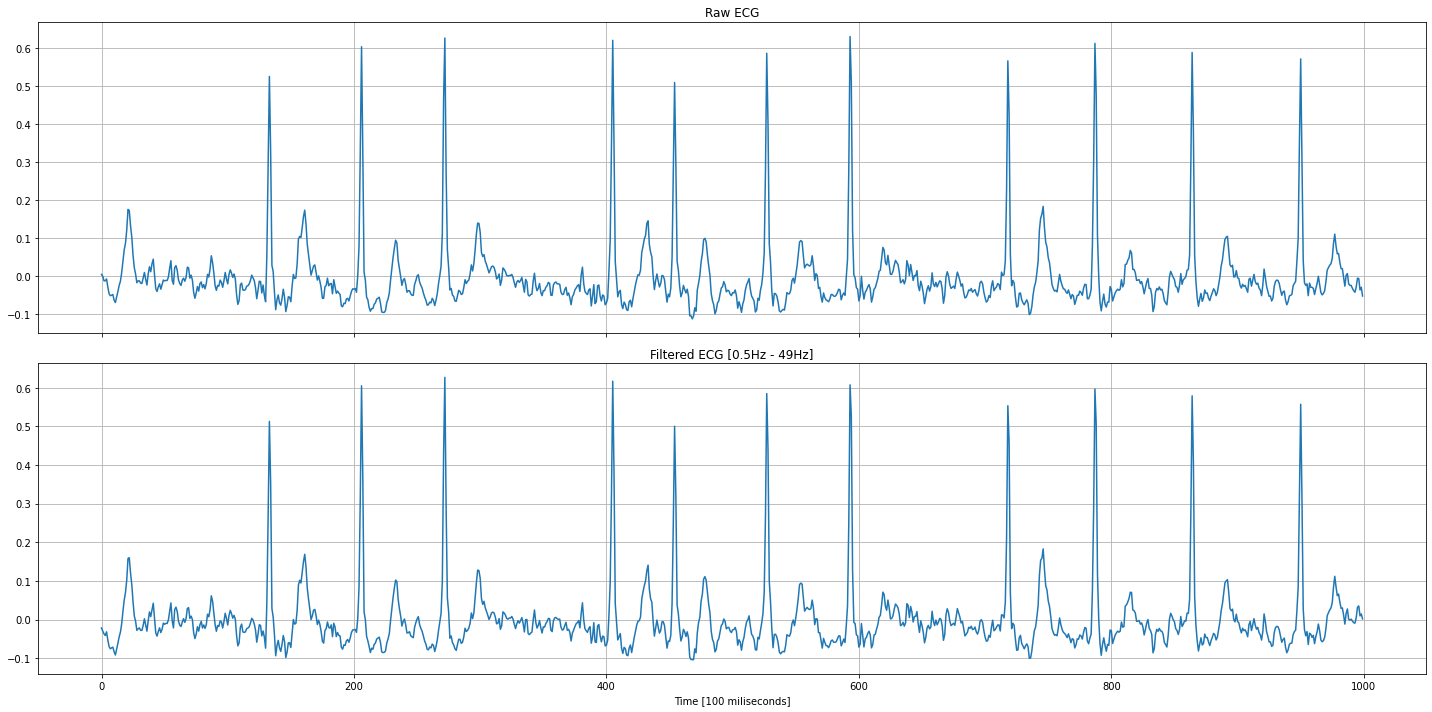

In [41]:
plt.figure(figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Raw ECG')
ax1.plot(X[294]);
ax1.grid()
ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
ax2.plot(final_filtered_data);
ax2.set_xlabel('Time [100 miliseconds]');
ax2.grid()
plt.tight_layout()
plt.show()
#ecg_plot()

In [119]:
from scipy.fft import fft, fftfreq

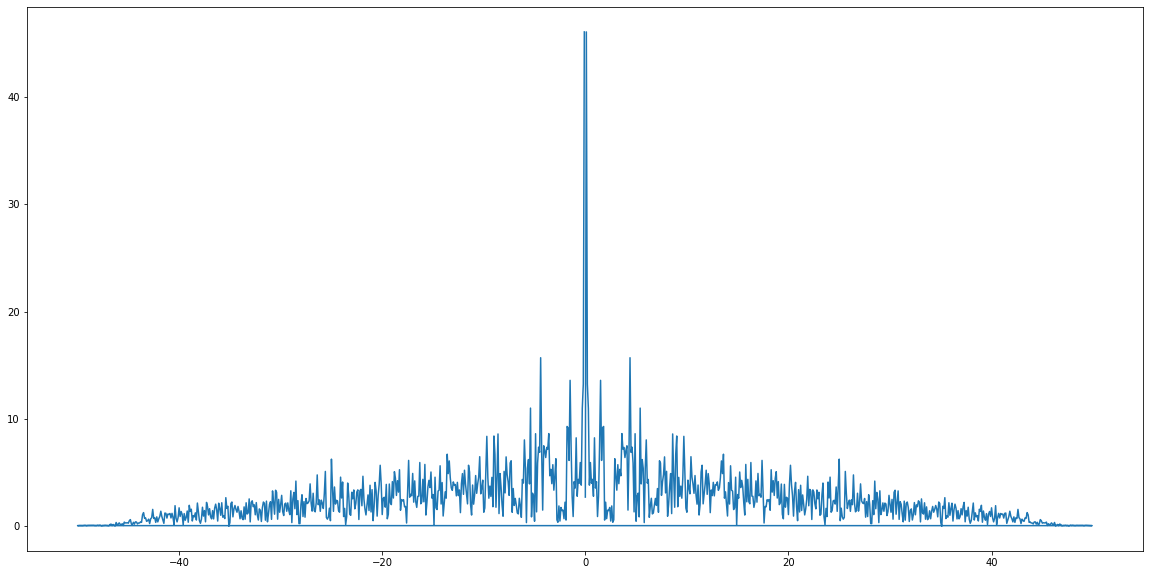

In [125]:
yf = fft(X[30])
xf = fftfreq(1000, 1 / 100)

plt.plot(xf, np.abs(yf))
plt.show()

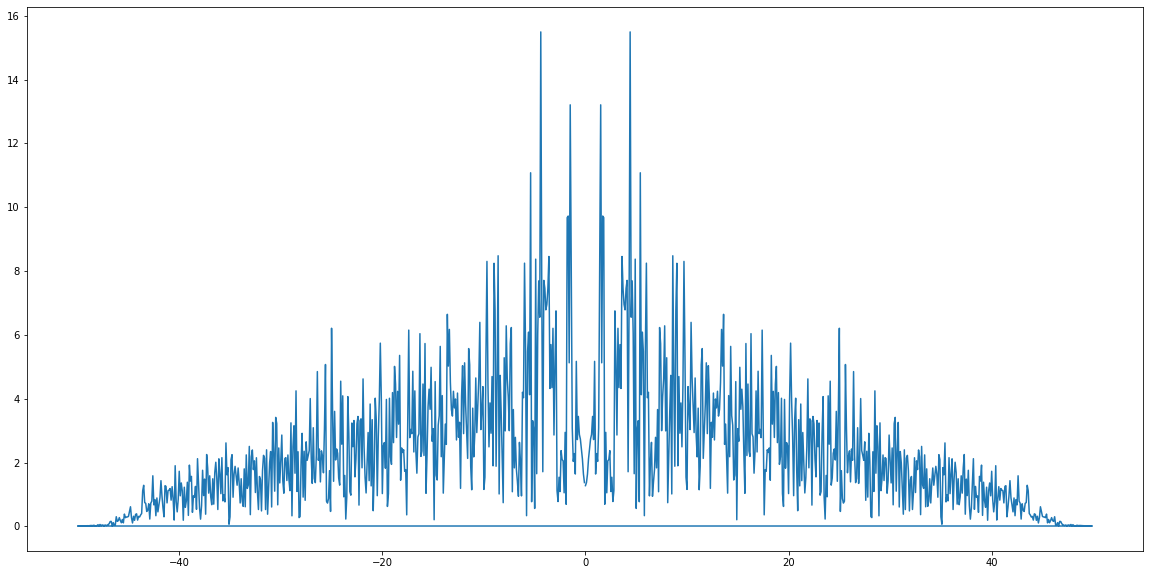

In [126]:
yf_final = fft(final_filtered_data)
xf_final = fftfreq(1000, 1 / 100)

plt.plot(xf_final, np.abs(yf_final))
plt.show()

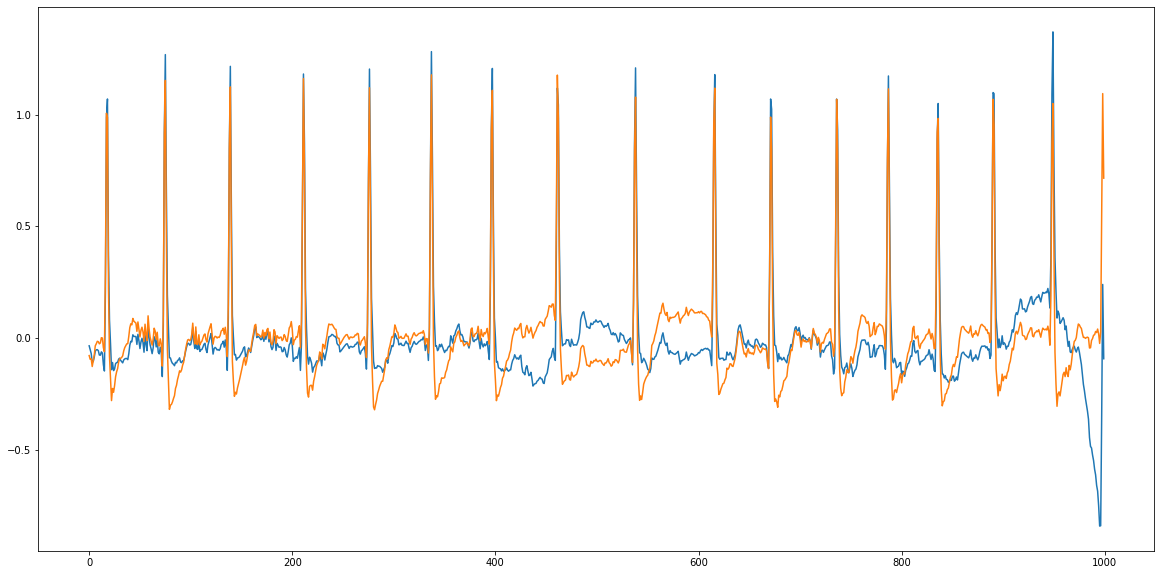

In [253]:
plt.plot(final_filtered_data)
plt.plot(final_filtered_data_2)

In [42]:
filtered_data_2 = highpass(X[294], 100, 0.67, 5)
final_filtered_data_2 = lowpass(filtered_data_2, 100, 49, 5)

<Figure size 1440x720 with 0 Axes>

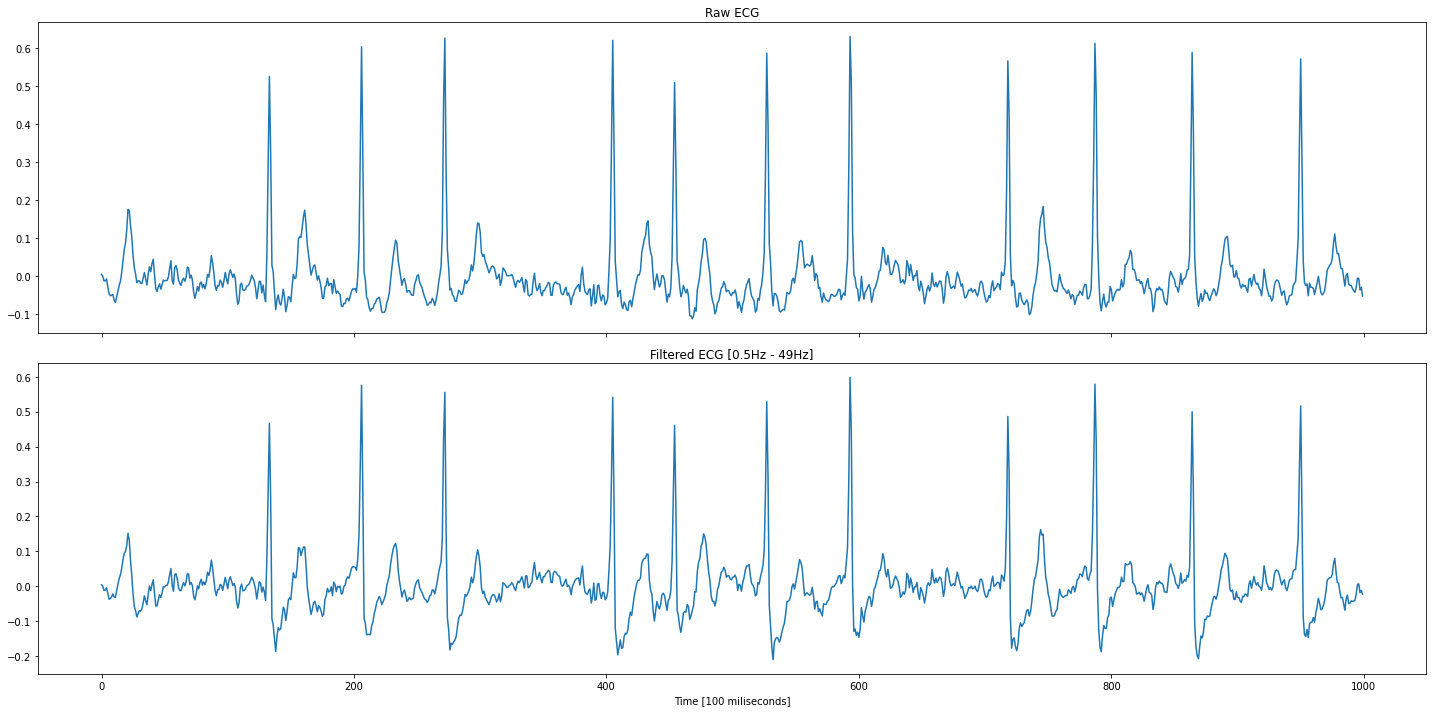

In [43]:
plt.figure(figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Raw ECG')
ax1.plot(X[294]);
ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
ax2.plot(final_filtered_data_2);
ax2.set_xlabel('Time [100 miliseconds]');
plt.tight_layout()
plt.show()

In [153]:
e, f = iirnotch(0.05, Q = 0.005, fs = 100)
bright_new_filtered_data = filtfilt(e, f, X[151])

In [154]:
filtered_data_3 = highpass(bright_new_filtered_data, 100, 0.5, 5)
bright_new_filtered_data_2 = lowpass(filtered_data_3, 100, 49, 5)

<Figure size 1440x720 with 0 Axes>

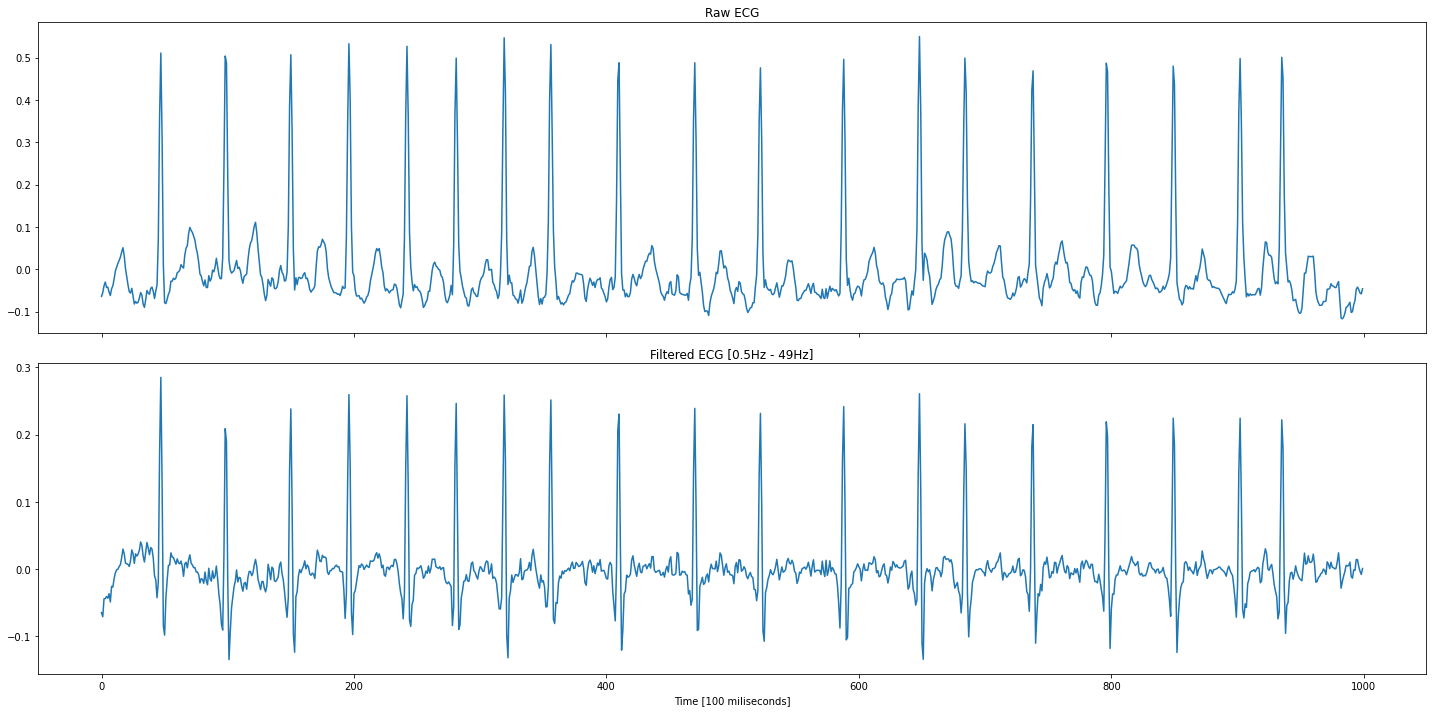

In [155]:
plt.figure(figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Raw ECG')
ax1.plot(X[151]);
ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
ax2.plot(bright_new_filtered_data_2);
ax2.set_xlabel('Time [100 miliseconds]');
plt.tight_layout()
plt.show()

In [54]:
b, a = butter_highpass(0.67, 100, 2)
n_filtered_data = filtfilt(b, a, X[11])

Text(0.5, 1.0, 'Filtered')

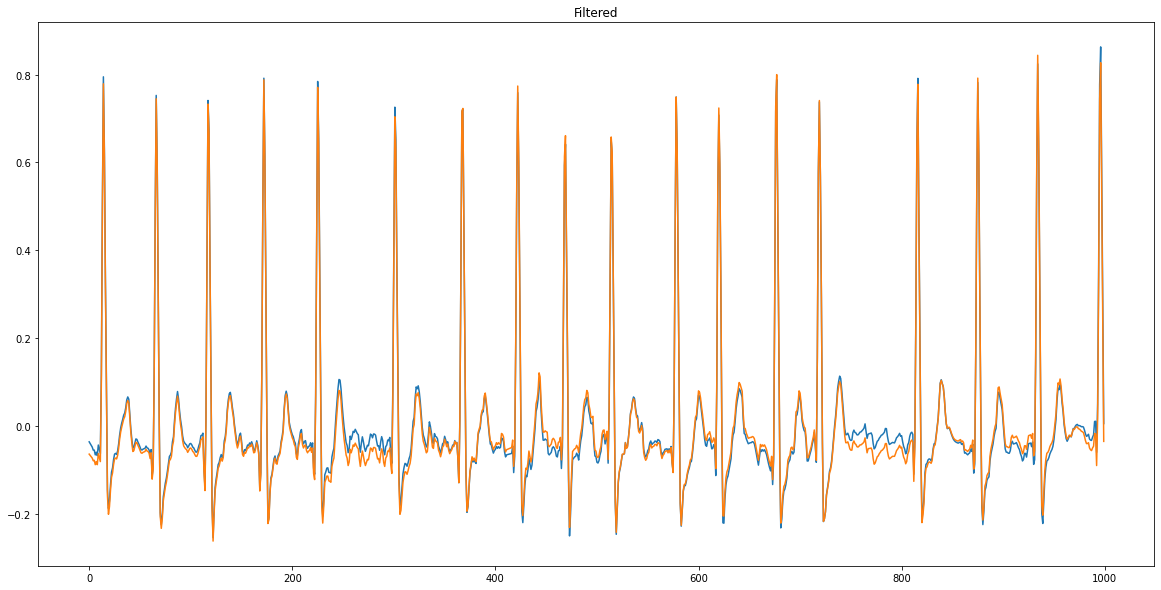

In [56]:
plt.plot(n_filtered_data)
plt.plot(X[15])
plt.title("Filtered")

In [179]:
new_final_filtered_data = lowpass(filtered_data, 100, 49, 5)

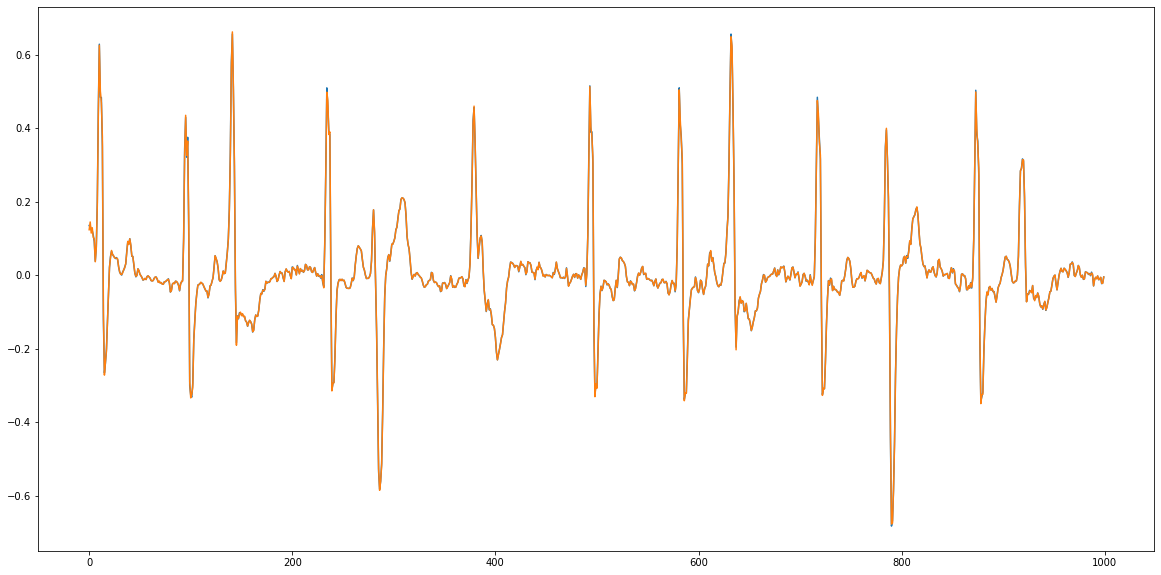

In [180]:
plt.plot(final_filtered_data)
plt.plot(new_final_filtered_data)

In [58]:
b, a = butter_highpass(0.67, 100, 2)
n_filtered_data = filtfilt(b, a, X[12])

<Figure size 1440x720 with 0 Axes>

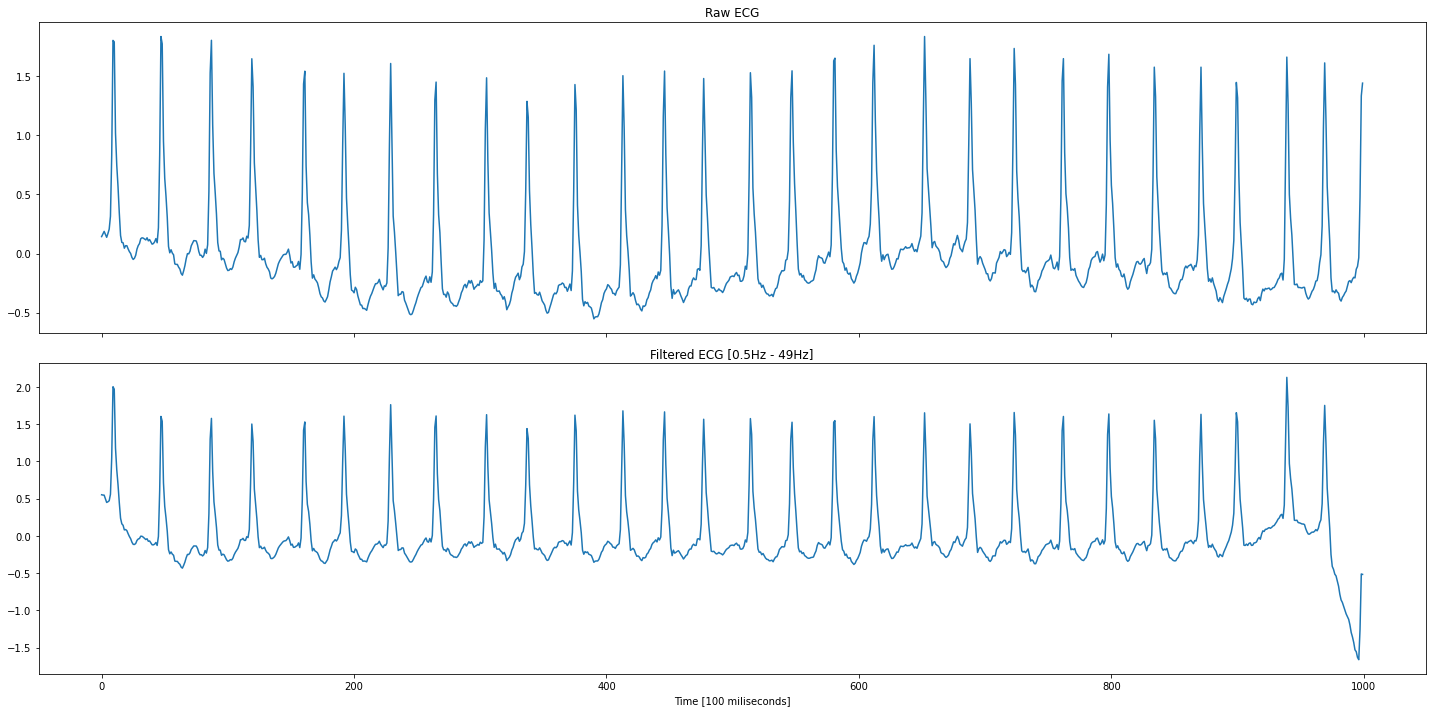

In [61]:
plt.figure(figsize=(20, 10))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title('Raw ECG')
ax1.plot(X[12]);
ax2.set_title('Filtered ECG [0.5Hz - 49Hz]')
ax2.plot(n_filtered_data);
ax2.set_xlabel('Time [100 miliseconds]');
plt.tight_layout()
plt.show()